## 1. Vanilla GAN

* Reference. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py, https://github.com/Yangyangii/pytorch-practice/blob/master/GAN.ipynb, https://arxiv.org/pdf/1406.2661

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os
import sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images ## generate를 사용하여 store 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) ## random noise tensor : z
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28) ## generate에서 나오는 결과물 28*28 크기로 100장
    result = y_hat.cpu().data.numpy() ## y_hat을 numpy 배열로 변환
    img = np.zeros([280, 280])
    for j in range(10):  ## 10번 반복
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img  ## [j*10:(j+1)*10] : 각 행의 시작과 끝을 나타냄

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1): ## 입력 크기 : 28*28 784, 출력 크기 : 1
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512), ## 입력 크기에서 512로 가는
            nn.LeakyReLU(0.2), ## activation function
            nn.Linear(512, 256), ## 512 -> 256
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),  ## activation function
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1) ## 입력 데이터를 '일렬로'
        y_ = self.layer(y_)
        return y_  ## 출력

In [ ]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28) ## 28*28 흑백 이미지
        return y_

In [ ]:
n_noise = 100

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16099933.37it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488540.99it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4375194.23it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2246789.57it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
## discriminate 파라미터를 가져와
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
## generate 파라미터를 가져와

In [ ]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [ ]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):  # max epoch만큼 돌리겠다
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)  ## image 저장 장치 옮기기
        x_outputs = D(x)  ## x 출력값 저장
        D_x_loss = criterion(x_outputs, D_labels)  ## D_labels 1로 설정되어있는 상태

        z = torch.randn(batch_size, n_noise).to(DEVICE)  ## random noise 설정해서 z에 저장
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)  ## D_fakes 보통 0으로 설정
        D_loss = D_x_loss + D_z_loss  ## real image loss + fake image loss

        D.zero_grad()  ## D = 0
        D_loss.backward(). ## D_loss calculate
        D_opt.step()

        if step % n_critic == 0:  ## step이 n_critic으로 나누어 떨어지는 경우에만 G 학습
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z)). ## D에 입력해서 fake image 예측 값에 대해 계산
            G_loss = criterion(z_outputs, D_labels)  ## generate loss에 대한 계산

            G.zero_grad()  ## G 기울기 0으로 초기화
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:  ## step이 500으로 나누어 떨어지는 경우에만 출력
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:  ## step이 1000으로 나누어 떨어지는 경우에만 출력
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.4289321899414062, G Loss: 0.7392334938049316
Epoch: 0/50, Step: 500, D Loss: 1.2724153995513916, G Loss: 0.8019099831581116
Epoch: 1/50, Step: 1000, D Loss: 1.2469027042388916, G Loss: 0.8860597610473633
Epoch: 1/50, Step: 1500, D Loss: 1.2539517879486084, G Loss: 1.3763192892074585
Epoch: 2/50, Step: 2000, D Loss: 1.223344087600708, G Loss: 1.1084800958633423
Epoch: 2/50, Step: 2500, D Loss: 1.3125618696212769, G Loss: 0.7289125919342041
Epoch: 3/50, Step: 3000, D Loss: 1.1579663753509521, G Loss: 0.9221238493919373
Epoch: 3/50, Step: 3500, D Loss: 1.1254267692565918, G Loss: 0.87974613904953
Epoch: 4/50, Step: 4000, D Loss: 1.2516891956329346, G Loss: 1.1482698917388916
Epoch: 4/50, Step: 4500, D Loss: 1.266981840133667, G Loss: 0.8502911329269409
Epoch: 5/50, Step: 5000, D Loss: 1.2132549285888672, G Loss: 0.8005305528640747
Epoch: 5/50, Step: 5500, D Loss: 1.2136616706848145, G Loss: 0.9266544580459595
Epoch: 6/50, Step: 6000, D Loss: 1.1948448419570

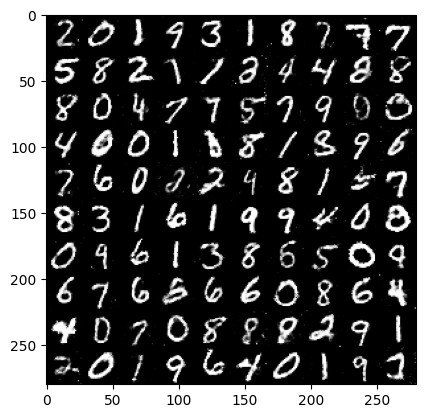

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [30]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

### Question 1. Explain the code of the '1. Vanilla GAN' section "briefly".

(완)

Now you're a deep learning expert too!
After this session, if you're interested in further study, I recommend exploring the following papers and codes:

(1) [Computer Vision] U-GAT-IT, Vision Transformer, (Mask, Fast, Faster) R-CNN, YOLO, Detectron(2), nnUnet, MobileNet, Neural Style Transfer

(2) [Natural Language Processing] KoBERT, BERT, KoBART, BART, ELECTRA

(3) [Audio] ResNeXt, ResMax, AASIST

(4) [Learning Technique] Curriculum Learning, Moco Encoder, Contrastive Learning, Student-teacher Model, Knowledge Distillation, Meta Learning

(5) [Machine Learning for Tabular data Analysis] SVM, LR, XGBoost, LightGBM, CatBoost, TabNet, AutoML (optuna)

Feel free to delve into these topics to deepen your understanding in various areas of AI! If you have any questions about specific topics or need more information, feel free to ask.